# Importing Library
In this section, we import all the necessary libraries and modules required for data handling, visualization, preprocessing, model building, and evaluation.

- **Data Handling & Visualization:**
  - `pandas`, `numpy`: For efficient data manipulation and numerical operations.
  - `matplotlib.pyplot`, `seaborn`: For data visualization and plotting.

- **Datasets:**
  - `datasets`: Used for loading and handling datasets in a structured way.

- **Preprocessing & Metrics:**
  - `sklearn.preprocessing`: For encoding categorical features.
  - `sklearn.metrics`: For evaluating model performance using metrics like accuracy, F1-score, ROC AUC, etc.

- **Model Selection:**
  - `train_test_split`: To split the dataset into training and test sets.
  - `Counter`: To count elements in arrays for class distribution.

- **ML Models (Alternative Baselines):**
  - `xgboost`, `lightgbm`: For benchmarking with tree-based ensemble models like XGBoost and LightGBM.

- **Miscellaneous:**
  - `random`, `math`, `os`, `time`, `datetime`: General-purpose modules.
  - `socket`, `whois`: Useful for extracting domain-related features (e.g., age, registrant info).
  - `BeautifulSoup`, `urllib`: For parsing and handling URLs and HTML content.

This diverse set of tools sets the stage for building both traditional ML baselines and deep learning-based models for malicious URL detection.


In [1]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.4
    Uninstalling huggingface-hub-0.23.4:
      Successfully uninstalled huggingface-hub-0.23.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.20.0
    Uninstalling datasets-2.20.0:
      Successfully uninstalled datasets-2.20.0
Note: you may need to restart the kernel to use updated packages.


In [80]:
!pip install torchviz

In [3]:
%%bash
pip install torch_optimizer numpy torch transformers evaluate python-whois --quiet
# The --quiet option is used to suppress the output of a pip command

In [46]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Import label encoder
from sklearn import preprocessing, metrics

import itertools
from sklearn.metrics import classification_report, mean_squared_error,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import random
import math
from collections import Counter
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os

from scipy.stats import entropy


# Data Understanding

In [5]:
df = pd.read_csv('/kaggle/input/malicious-urls-dataset/malicious_phish.csv')

### Dataset Information

In [6]:
print(df.shape)
print(df.info())

(651191, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


In [7]:
df.groupby('type').apply(lambda x: x.sample(1)).reset_index(drop=True)

,url,type
0,montreal.en.craigslist.ca/spa/,benign
1,http://www.poly-murau.at/index.php?option=com_...,defacement
2,http://159.203.2.6/beastmode/b3astmode.arm5,malware
3,www.jetcafe.org/~npc/isp/free.html,phishing


In [8]:
df.isna().sum()

url     0
type    0
dtype: int64

### Data Distribution
In this section, we analyze and visualize the distribution of different types of URLs in the dataset.

- First, we extract the `type` column from the dataset, which indicates whether a URL is benign, phishing, malware, etc.
- Using `collections.Counter`, we count how many instances belong to each class.
- The types and their counts are sorted in descending order for a clearer visual representation.
- We also compute the percentage share of each type for better insight.

The bar chart below shows:
- The **number of URLs per type** on the y-axis.
- The **URL categories** on the x-axis (e.g., benign, phishing, defacement).
- Each bar is annotated with both the **count** and **percentage** of the total dataset it represents.

This visualization helps us understand if the dataset is **balanced or imbalanced**, which is crucial when designing and evaluating classification models.

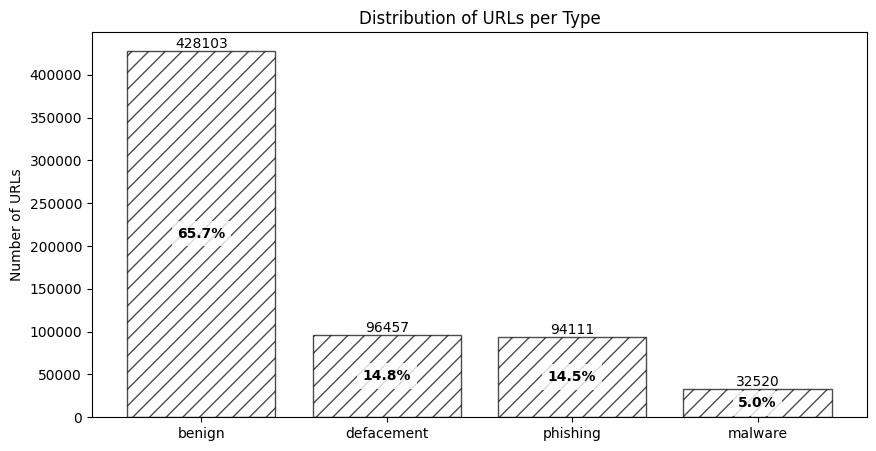

Counter({'benign': 428103, 'defacement': 96457, 'phishing': 94111, 'malware': 32520})


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

types = df['type'].values

counter_types = Counter(types)

type_names = list(counter_types.keys())
type_values = list(counter_types.values())

sorted_indices = np.argsort(type_values)[::-1]
type_names = [type_names[i] for i in sorted_indices]
type_values = [type_values[i] for i in sorted_indices]

total_count = sum(type_values)
percentages = [value / total_count * 100 for value in type_values]

pattern = '//'

y_pos = np.arange(len(type_names))
plt.figure(1, figsize=(10, 5))
bars = plt.bar(y_pos, type_values, align='center', alpha=0.7, color='none', edgecolor='black', hatch=pattern)

for bar, value, percentage in zip(bars, type_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontweight='bold')

plt.xticks(y_pos, type_names)
plt.ylabel('Number of URLs')
plt.title('Distribution of URLs per Type')
plt.show()

print(counter_types)

In [10]:
df['url_len'] = [len(url) for url in df.url]
df.head()

,url,type,url_len
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235


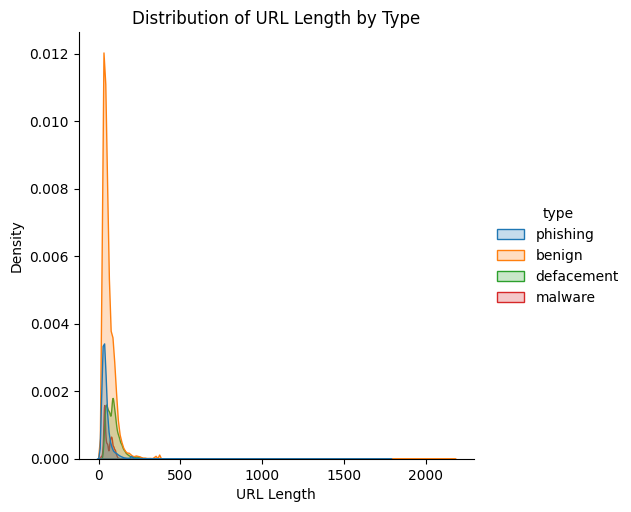

In [11]:
# Plot distribution of 'url_len' for each 'type'
sns.displot(df, x='url_len', hue='type', kind='kde', fill=True)

# Add labels and title
plt.xlabel('URL Length')
plt.ylabel('Density')
plt.title('Distribution of URL Length by Type')
plt.show()

# Data Preparation

## Label Encoding

To prepare the dataset for machine learning models, we convert the categorical target labels (`type`) into numerical format using **Label Encoding**.

- `LabelEncoder` from `sklearn.preprocessing` is used to assign a unique integer to each URL type (e.g., benign → 0, phishing → 1, etc.).
- A new column `type_code` is added to the DataFrame to store these encoded labels.
- We also create a mapping dictionary `le_label_mapping` to preserve the relationship between the original string labels and their corresponding numeric codes.

This transformation allows our models to interpret the target variable during training.

In [12]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
le.fit(df["type"])

df["type_code"] = le.transform(df["type"])
df

,url,type,url_len,type_code
0,br-icloud.com.br,phishing,16,3
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,1
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,44,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,45,3


In [13]:
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_label_mapping

{'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}

### Splitting

To build and evaluate a robust model, we split the dataset into three distinct sets:

1. **Selecting Relevant Columns**:
   - We keep only the `url`, `type`, and the encoded `type_code` columns for modeling.

2. **Conversion to Hugging Face Dataset**:
   - The DataFrame is converted to a `datasets.Dataset` object from the Hugging Face `datasets` library, which provides powerful tools for dataset handling.

3. **Creating the Train-Test Split**:
   - We split the dataset into 80% **training** and 20% **testing** sets using `train_test_split`, with shuffling for randomness.

4. **Further Splitting for Validation**:
   - The 20% test set is further split evenly into:
     - 10% **validation set**
     - 10% **final test set**
   - This ensures that we maintain the overall 80/10/10 split for training, validation, and testing respectively.

5. **Combining into a DatasetDict**:
   - The resulting splits are organized into a `DatasetDict` for structured and easy access during model training and evaluation.

This splitting strategy helps us monitor training progress, tune hyperparameters, and evaluate final performance on unseen data.

In [14]:
df = df[['url', 'type', 'type_code']]
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset

Dataset({
    features: ['url', 'type', 'type_code'],
    num_rows: 651191
})

In [15]:
# split train to 80% of total and test to 20% of total
train_test_dataset = dataset.train_test_split(test_size=0.3, seed=42, shuffle=True)
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 455833
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 195358
    })
})

In [16]:
# split the validation test to 10% of total and test set to 10% of total
val_test_dataset = train_test_dataset['test'].train_test_split(test_size=0.5, seed=42, shuffle=True)
val_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 97679
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 97679
    })
})

In [17]:
from datasets import DatasetDict

# 80% train, 10% validation, 10% test
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'val': val_test_dataset['train'],
    'test': val_test_dataset['test'],
})
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 455833
    })
    val: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 97679
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 97679
    })
})

### Importing Huggingface Data

In [18]:
dataset = load_dataset("bgspaditya/byt-mal-minpro")
dataset = dataset.rename_column("type_code", "labels")
dataset

README.md:   0%|          | 0.00/744 [00:00<?, ?B/s]

(…)-00000-of-00001-4d98c140ad251f09.parquet:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

(…)-00000-of-00001-660325714818dbe4.parquet:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

(…)-00000-of-00001-bcccbefe8f568c54.parquet:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/520952 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/65119 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/65120 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65120
    })
})

In [19]:
dataset = load_dataset("bgspaditya/byt-mal-minpro")
dataset = dataset.rename_column("type_code", "labels")
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65120
    })
})

# Feature Engineering

In [20]:
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['val'])

## Check IP
To disguise the identity of a website, online criminals frequently use an Internet protocol address instead of the domain name server. This feature will determine if the URL contains an IP address or not

In [21]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df_train['use_of_ip'] = df_train['url'].apply(lambda i: having_ip_address(i))
df_test['use_of_ip'] = df_test['url'].apply(lambda i: having_ip_address(i))

df_train

,url,type,labels,use_of_ip
0,tools.ietf.org/html/rfc1328,phishing,3,0
1,twnty.com/,benign,0,0
2,pianoplus.ca/,benign,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0
...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0


## Abnormal URL
The WHOIS database may be used to extract this feature. Identity is commonly
included in the URL of a trustworthy website

In [22]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df_train['abnormal_url'] = df_train['url'].apply(lambda i: abnormal_url(i))
df_test['abnormal_url'] = df_test['url'].apply(lambda i: abnormal_url(i))
df_train

,url,type,labels,use_of_ip,abnormal_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0
1,twnty.com/,benign,0,0,0
2,pianoplus.ca/,benign,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0
...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1


## Count of dot (.)
The URLs of phishing or malware websites frequently contain more than two subdomains. A dot separates each domain (.). Every URL with more than three dot characters (.)
raises the risk of a malicious website

In [23]:
df_train['count.'] = df_train['url'].apply(lambda i: i.count('.'))
df_test['count.'] = df_test['url'].apply(lambda i: i.count('.'))

df_train.head()

,url,type,labels,use_of_ip,abnormal_url,count.
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2
1,twnty.com/,benign,0,0,0,1
2,pianoplus.ca/,benign,0,0,0,1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3


## Count of WWW (www.)
The majority of secure websites typically only contain one www in their URLs. If
the URL has no www or more than one www, this feature aids in the detection of fraudulent
websites.

In [24]:
df_train['count-www'] = df_train['url'].apply(lambda i: i.count('www'))
df_test['count-www'] = df_test['url'].apply(lambda i: i.count('www'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0
1,twnty.com/,benign,0,0,0,1,0
2,pianoplus.ca/,benign,0,0,0,1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0
...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0


## Count (@)
If the URL contains the "@" sign, everything before it is ignored

In [25]:
df_train['count@'] = df_train['url'].apply(lambda i: i.count('@'))
df_test['count@'] = df_test['url'].apply(lambda i: i.count('@'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0
1,twnty.com/,benign,0,0,0,1,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0
...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0


## Count Dir / URL Depth
Websites that have several directories in their URLs are typically suspect

In [26]:
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df_train['count_dir'] = df_train['url'].apply(lambda i: no_of_dir(i))
df_test['count_dir'] = df_test['url'].apply(lambda i: no_of_dir(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2
1,twnty.com/,benign,0,0,0,1,0,0,1
2,pianoplus.ca/,benign,0,0,0,1,0,0,1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7
...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2


## Count Embed Domain
Knowing how many embedded domains there are will help you spot
dangerous URLs. You may accomplish it by looking for the character "//" in the URL

In [27]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df_train['count_embed_domian'] = df_train['url'].apply(lambda i: no_of_embed(i))
df_test['count_embed_domian'] = df_test['url'].apply(lambda i: no_of_embed(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0
...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0


## Count Suspicious URL


In [28]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['sus_url'] = df_train['url'].apply(lambda i: suspicious_words(i))
df_test['sus_url'] = df_test['url'].apply(lambda i: suspicious_words(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0


## Count Shortening URL
This feature tells you whether a URL has been shortened using a service, such as bit.ly,
goo.gl, go2l.ink, etc

In [29]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['short_url'] = df_train['url'].apply(lambda i: shortening_service(i))
df_test['short_url'] = df_test['url'].apply(lambda i: shortening_service(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0


## Count HTTPS
Malicious Websites often avoid using HTTPS protocols since they typically demand
user login information and guarantee that online transactions are secure. Hence, whether HTTPS is
present or not is a key component of the URL.

In [30]:
df_train['count-https'] = df_train['url'].apply(lambda i : i.count('https'))
df_test['count-https'] = df_test['url'].apply(lambda i : i.count('https'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0


## Count HTTP
Safe websites typically have a single HTTP in their URL, but phishing or malicious
websites frequently have several HTTPs.

In [31]:
df_train['count-http'] = df_train['url'].apply(lambda i : i.count('http'))
df_test['count-http'] = df_test['url'].apply(lambda i : i.count('http'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1


## Count (%)
As we all know, spaces are not permitted in URLs. Normal URL encoding substitutes
the symbol (%) for spaces. Secure websites typically have less spaces in their URLs than
dangerous ones, which means that they have more spaces overall.

In [32]:
df_train['count%'] = df_train['url'].apply(lambda i: i.count('%'))
df_test['count%'] = df_test['url'].apply(lambda i: i.count('%'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0


## Count (-)
To make a Website appear legitimate, phishers and other cybercriminals frequently add
dashes (-) to the brand name's prefix or suffix. An illustration. www.flipkart-india.com.

In [33]:
df_train['count-'] = df_train['url'].apply(lambda i: i.count('-'))
df_test['count-'] = df_test['url'].apply(lambda i: i.count('-'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0


## Count (=)
The equal sign (=) in the URL denotes that variables are being sent from one form page
to another. As anybody may alter the values in a URL to change the page, it is regarded as being
riskier

In [34]:
df_train['count='] = df_train['url'].apply(lambda i: i.count('='))
df_test['count='] = df_test['url'].apply(lambda i: i.count('='))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1


## URL Length
To conceal the domain name, attackers frequently utilize lengthy URLs. We
discovered that a safe URL typically has a length of 74 characters

In [35]:
df_train['url_length'] = df_train['url'].apply(lambda i: len(str(i)))
df_test['url_length'] = df_test['url'].apply(lambda i: len(str(i)))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123


## Hostname Length
The hostname's length is a crucial element in identifying fraudulent URLs

In [36]:
df_train['hostname_length'] = df_train['url'].apply(lambda i: len(urlparse(i).netloc))
df_test['hostname_length'] = df_test['url'].apply(lambda i: len(urlparse(i).netloc))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length,hostname_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68,19
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100,7
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123,12


In [37]:
!pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.9 MB/s eta 0:00:00a 0:00:01


## First Directory Length
With this feature, you may figure out how long the URL's first directory
is. In order to get the first directory length of the URL, check for the initial '/' and count the length
of the URL up to this point. Installing the Python TLD library is required to obtain directory-level
information. You may install TLD by visiting this page

In [38]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df_train['fd_length'] = df_train['url'].apply(lambda i: fd_length(i))
df_test['fd_length'] = df_test['url'].apply(lambda i: fd_length(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,sus_url,short_url,count-https,count-http,count%,count-,count=,url_length,hostname_length,fd_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,0,0,0,0,0,0,0,27,0,4
1,twnty.com/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,10,0,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,13,0,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,0,0,0,1,0,3,0,68,19,18
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,0,0,0,0,0,0,0,55,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,0,1,0,0,0,7,0,80,0,4
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,0,0,0,1,0,12,0,100,7,8
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,0,0,0,0,0,6,0,46,0,3
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,0,0,0,1,0,0,1,123,12,7


## TLD Length
one of the domains at the top of the Internet's hierarchical domain
name system is a top-level domain (TLD). For instance, the top-level domain is com in the domain
name www.example.com. So, the length of the TLD is crucial for recognizing fraudulent URLs.
since.com is the most common extension for URLs. TLDs encompassing.

In [39]:
#Length of Top Level Domain
df_train['tld'] = df_train['url'].apply(lambda i: get_tld(i,fail_silently=True))
df_test['tld'] = df_test['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df_train['tld_length'] = df_train['tld'].apply(lambda i: tld_length(i))
df_test['tld_length'] = df_test['tld'].apply(lambda i: tld_length(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-https,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,0,27,0,4,None,-1
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,0,10,0,0,None,-1
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,0,13,0,0,None,-1
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,0,1,0,3,0,68,19,18,dk,2
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,0,55,0,4,None,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,0,7,0,80,0,4,None,-1
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,0,1,0,12,0,100,7,8,com,3
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,0,6,0,46,0,3,None,-1
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,1,0,0,1,123,12,7,net,3


## Digit Count
Suspicious URLs are often those that contain numbers. Counting the amount of
digits in a URL is a key characteristic for identifying fraudulent URLs because safe URLs often
do not include digits

In [40]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df_train['count-digits']= df_train['url'].apply(lambda i: digit_count(i))
df_test['count-digits']= df_test['url'].apply(lambda i: digit_count(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,None,-1,4
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,None,-1,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,None,-1,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,dk,2,9
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,None,-1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,7,0,80,0,4,None,-1,10
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,1,0,12,0,100,7,8,com,3,6
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,6,0,46,0,3,None,-1,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,1,0,0,1,123,12,7,net,3,33


## Letter Count
Another important factor in recognizing fraudulent URLs is the number of letters
in the URL. Attackers typically accomplish this by adding more letters and numbers to the URL in
an effort to lengthen it and conceal the domain name.

In [41]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df_train['count-letters']= df_train['url'].apply(lambda i: letter_count(i))
df_test['count-letters']= df_test['url'].apply(lambda i: letter_count(i))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count%,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,27,0,4,None,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,10,0,0,None,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,13,0,0,None,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,0,3,0,68,19,18,dk,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,55,0,4,None,-1,8,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,7,0,80,0,4,None,-1,10,57
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,0,12,0,100,7,8,com,3,6,75
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,6,0,46,0,3,None,-1,0,37
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,0,1,123,12,7,net,3,33,74


In [42]:
df_train = df_train.drop("tld",axis=1)
df_test = df_test.drop("tld",axis=1)
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,-1,8,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,0,0,7,0,80,0,4,-1,10,57
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,1,0,12,0,100,7,8,3,6,75
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,0,0,6,0,46,0,3,-1,0,37
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,1,0,0,1,123,12,7,3,33,74


In [43]:
df_train.head()

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,0,27,0,4,-1,4,19
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,10,0,0,-1,0,8
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,0,13,0,0,-1,0,11
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,0,3,0,68,19,18,2,9,46
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,0,55,0,4,-1,8,37


#### 🔍 URL-Based Feature Functions:
- `extract_hostname(url)`: Parses the hostname from the URL.
- `extract_tld(hostname)`: Extracts the top-level domain (TLD) from the hostname.

#### ⚠️ Heuristic-Based Features:
- `has_ip_address(url)`: Checks if the URL contains a raw IP address.
- `has_suspicious_words(url)`: Detects presence of phishing-related keywords like `login`, `verify`, `banking`, etc.
- `is_encoded_url(url)`: Checks for percent-encoded characters (`%`) in the URL.
- `has_double_slash_redirect(url)`: Checks if there's a double slash redirect beyond the protocol.
- `count_special_chars(url)`: Counts non-alphanumeric characters in the URL, which may indicate obfuscation.
- `is_hex_encoded(url)`: Identifies hex-encoded values (e.g., `%20`) commonly used in malicious URLs.
- `shannon_entropy(url)`: Calculates the entropy of characters in the URL; higher entropy may indicate randomness and obfuscation.
- `is_suspicious_tld(tld)`: Flags TLDs commonly associated with malicious domains (`tk`, `ml`, `cf`, etc.).
- `is_free_host(hostname)`: Detects if the hostname belongs to known free hosting providers.
- `count_subdomains(hostname)`: Counts the number of subdomains as phishing URLs often use many subdomains to mimic legit sites.

#### 🚀 Full Feature Pipeline:
- The function `add_url_features(df)` applies all of the above logic:
  - It extracts `hostname` and `tld` from each URL.
  - It computes and adds all the engineered features as new columns to the DataFrame.

These handcrafted features help improve model interpretability and performance, especially when used in conjunction with deep learning or traditional ML methods.

In [47]:
from urllib.parse import urlparse

# ⚙️ Extract hostname and tld from url
def extract_hostname(url):
    try:
        return urlparse(url).hostname
    except:
        return ''

def extract_tld(hostname):
    try:
        return hostname.split('.')[-1] if hostname else ''
    except:
        return ''

# 🧠 Feature Engineering Functions (same as before)
def has_ip_address(url):
    return 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', url) else 0

def has_suspicious_words(url):
    suspicious_keywords = ['login', 'secure', 'account', 'update', 'verify', 'banking', 'signin']
    return 1 if any(word in url.lower() for word in suspicious_keywords) else 0

def is_encoded_url(url):
    return 1 if '%' in url else 0

def has_double_slash_redirect(url):
    return 1 if '//' in url.split('//')[-1] else 0

def count_special_chars(url):
    return sum(1 for c in url if not c.isalnum())

def is_hex_encoded(url):
    return 1 if re.search(r'%[0-9a-fA-F]{2}', url) else 0

def shannon_entropy(url):
    prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(list(url))]
    return round(entropy(prob, base=2), 2)

def is_suspicious_tld(tld):
    return 1 if tld in ['tk', 'ml', 'ga', 'cf', 'gq'] else 0

def is_free_host(hostname):
    free_hosts = ['000webhost', 'weebly', 'wix', 'blogspot']
    return 1 if any(fh in (hostname or '') for fh in free_hosts) else 0

def count_subdomains(hostname):
    return hostname.count('.') if hostname else 0

# ✅ Full Pipeline with Automatic Extraction
def add_url_features(df):
    df = df.copy()

    # 1. Extract hostname and tld
    df['hostname'] = df['url'].apply(extract_hostname)
    df['tld'] = df['hostname'].apply(extract_tld)

    # 2. Add engineered features
    df['has_ip'] = df['url'].apply(has_ip_address)
    df['has_suspicious_word'] = df['url'].apply(has_suspicious_words)
    df['is_encoded'] = df['url'].apply(is_encoded_url)
    df['contains_double_slash_redirect'] = df['url'].apply(has_double_slash_redirect)
    df['count_special_chars'] = df['url'].apply(count_special_chars)
    df['is_hex_encoded'] = df['url'].apply(is_hex_encoded)
    df['url_entropy'] = df['url'].apply(shannon_entropy)
    df['is_tld_suspicious'] = df['tld'].apply(is_suspicious_tld)
    df['is_free_host'] = df['hostname'].apply(is_free_host)
    df['count_subdomains'] = df['hostname'].apply(count_subdomains)

    return df


In [48]:


# ✅ Usage
df_train = add_url_features(df_train)


In [49]:
df_test = add_url_features(df_test)


# Data Splitting

In [50]:
# ✅ Select updated predictor variables with newly engineered features
X_train = df_train[[
    'use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
    'count_dir', 'count_embed_domian', 'short_url', 'count-https',
    'count-http', 'count%', 'count-', 'count=', 'url_length',
    'hostname_length', 'sus_url', 'fd_length', 'tld_length',
    'count-digits', 'count-letters',

    # ➕ Newly engineered features
    'has_ip', 'has_suspicious_word', 'is_encoded', 'contains_double_slash_redirect',
    'count_special_chars', 'is_hex_encoded', 'url_entropy', 'is_tld_suspicious',
    'is_free_host', 'count_subdomains'
]]

# ✅ Target variable
y_train = df_train['labels']


In [51]:
# ✅ Select updated predictor variables with newly engineered features
X_test = df_test[[
    'use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
    'count_dir', 'count_embed_domian', 'short_url', 'count-https',
    'count-http', 'count%', 'count-', 'count=', 'url_length',
    'hostname_length', 'sus_url', 'fd_length', 'tld_length',
    'count-digits', 'count-letters',

    # ➕ Newly engineered features
    'has_ip', 'has_suspicious_word', 'is_encoded', 'contains_double_slash_redirect',
    'count_special_chars', 'is_hex_encoded', 'url_entropy', 'is_tld_suspicious',
    'is_free_host', 'count_subdomains'
]]

# ✅ Target variable
y_test = df_test['labels']


In [52]:
X_train.to_csv('./x-train.csv')
y_train.to_csv('./y-train.csv')
X_test.to_csv('./x-test.csv')
y_test.to_csv('./y-test.csv')

# Modeling

In [53]:
eval_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-macro', 'F1-micro', 'F1-weighted'])
eval_df

,Model,Accuracy,F1-macro,F1-micro,F1-weighted


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

### ✅ Loading and Normalizing Data

In this section, we load the training and testing data from CSV files and perform normalization to ensure that features have a similar scale, which improves model performance.

1. **Loading Data**:
   - We load the feature matrices (`X_train` and `X_test`) and the target labels (`y_train` and `y_test`) from CSV files using `pandas.read_csv`.
   - The `index_col=0` parameter is used to ensure that the first column is treated as the index and doesn't become part of the data.

2. **Normalization**:
   - We use **StandardScaler** from `sklearn.preprocessing` to standardize the data.
   - The `fit_transform()` method is applied to the training data (`X_train`), calculating the mean and standard deviation to scale the features.
   - The `transform()` method is applied to the test data (`X_test`) using the parameters learned from the training set to ensure consistency in scaling.

Normalization helps in bringing all features to a similar scale, which is particularly important for models like neural networks, where differences in feature scale can adversely affect training.


In [55]:
# ✅ Load Data
X_train = pd.read_csv('./x-train.csv', index_col=0).values
y_train = pd.read_csv('./y-train.csv', index_col=0).values.ravel()
X_test = pd.read_csv('./x-test.csv', index_col=0).values
y_test = pd.read_csv('./y-test.csv', index_col=0).values.ravel()

# ✅ Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### ✅ Reshaping Data for CNN + RNN and Tensor Conversion

To prepare the data for use with deep learning models (specifically CNNs and RNNs), we need to reshape the feature matrix and convert the data into PyTorch tensors for efficient computation.

1. **Reshaping the Data**:
   - The input data (`X_train` and `X_test`) is reshaped to fit the expected input format for CNN + RNN models. 
   - The shape is modified to `(batch_size, channels, features)`, where:
     - `batch_size` is the number of samples,
     - `channels=1` since we're working with a 1D feature space,
     - `features` is the number of features in each sample.
   - This reshaping is crucial as CNNs often expect data in the form of `(batch_size, channels, height, width)`, but here we treat each URL as a sequence of features.

2. **Converting to PyTorch Tensors**:
   - We convert the reshaped NumPy arrays into PyTorch tensors with appropriate data types: 
     - `X_train_tensor` and `X_test_tensor` are the feature tensors (float32),
     - `y_train_tensor` and `y_test_tensor` are the target labels (long integers).

3. **Creating DataLoader**:
   - A **`TensorDataset`** is created to wrap the tensors for efficient batching.
   - We then use **`DataLoader`** to load the training data in batches of 64 samples, with shuffling enabled to improve training by ensuring randomness in each batch.

This preparation ensures the data is in the right format for training with deep learning models using PyTorch.


In [56]:
# ✅ Reshape for CNN+RNN
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (batch, channel=1, features)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# ✅ Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# ✅ DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

### ✅ CNN + BiLSTM Model with Dropout + Batch Normalization (No Attention)

This model combines Convolutional Neural Networks (CNN) and Bidirectional Long Short-Term Memory (BiLSTM) networks with **Dropout** and **Batch Normalization** to classify URLs into different categories.

#### 1. **Model Architecture**:

- **CNN Layer**:
  - The model starts with a **1D Convolutional layer** (`nn.Conv1d`), which helps in automatically extracting features from the URL sequence. 
  - It uses `cnn_out_channels` to define the number of filters, which is set to 32 by default.
  - **Batch Normalization** (`nn.BatchNorm1d`) is applied after the convolutional layer to stabilize and speed up the training process.
  - **ReLU activation** (`nn.ReLU`) is used to introduce non-linearity and enhance the model's ability to learn complex patterns.

- **BiLSTM Layer**:
  - The **Bidirectional LSTM** (`nn.LSTM`) is used to capture long-term dependencies in the feature sequence. It processes the features in both forward and backward directions, providing richer contextual information.
  - The `hidden_size` parameter defines the number of LSTM units (64 by default), and `bidirectional=True` ensures that the LSTM is bidirectional, meaning it processes sequences in both directions.

- **Fully Connected (FC) Layers**:
  - After passing through the BiLSTM, the output from the last time step is taken (using `lstm_out[:, -1, :]`). This represents the final feature representation of the entire sequence.
  - A fully connected layer (`nn.Linear`) is applied to transform this representation into a 64-dimensional vector (`fc1`), followed by **ReLU activation**.
  - Another fully connected layer (`fc2`) reduces the output to the number of classes (`num_classes`), which is 4 in this case (for 4 different types of URLs).

- **Dropout**:
  - Dropout (`nn.Dropout`) is applied to the intermediate layer's output (after the first fully connected layer). Dropout helps to prevent overfitting by randomly setting some of the activations to zero during training.

#### 2. **Forward Pass**:
The forward pass defines how the input flows through the layers of the model:
  1. The input goes through the CNN layer, followed by **Batch Normalization** and **ReLU** activation.
  2. The output from the CNN layer is reshaped (using `permute()`) to fit the BiLSTM input format.
  3. The output of the BiLSTM layer is passed through the fully connected layers (`fc1` and `fc2`).
  4. **Dropout** is applied after the first fully connected layer to reduce overfitting.
  5. Finally, the model outputs the predictions for each class using the second fully connected layer (`fc2`).

This model architecture leverages both CNN and BiLSTM layers to capture spatial and temporal dependencies in the input data, with added regularization techniques like **Batch Normalization** and **Dropout** to improve generalization.


In [57]:
# ✅ Model with Dropout + Batch Normalization (No Attention)
class CNN_BiLSTM(nn.Module):
    def __init__(self, input_features, cnn_out_channels=32, hidden_size=64, num_classes=4, dropout_rate=0.5):
        super(CNN_BiLSTM, self).__init__()
        
        # CNN Layer with BatchNorm
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(cnn_out_channels)  # BatchNorm
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout
        
        # BiLSTM Layer
        self.bilstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=hidden_size, 
                              batch_first=True, bidirectional=True)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        # CNN + BatchNorm
        x = self.relu(self.bn1(self.conv1(x)))  # (batch, cnn_out, features)
        x = x.permute(0, 2, 1)  # (batch, features, cnn_out)
        
        # BiLSTM Layer
        lstm_out, _ = self.bilstm(x)  # (batch, seq_len, hidden*2)
        
        # Fully Connected + Dropout
        x = self.relu(self.fc1(lstm_out[:, -1, :]))  # Use only the last output from LSTM
        x = self.dropout(x)  # Dropout applied here
        return self.fc2(x)




### ✅ CNN + BiLSTM Model with Dropout + Batch Normalization + Attention

This model combines **Convolutional Neural Networks (CNN)**, **Bidirectional Long Short-Term Memory (BiLSTM)**, and an **Attention mechanism** with **Dropout** and **Batch Normalization** to classify URLs into different categories.

#### 1. **Model Architecture**:

- **CNN Layer**:
  - The model begins with a **1D Convolutional layer** (`nn.Conv1d`), designed to automatically extract features from the sequence of characters in the URL.
  - The number of filters (output channels) is defined by `cnn_out_channels`, which is set to 32 by default.
  - **Batch Normalization** (`nn.BatchNorm1d`) is applied after the convolutional layer to stabilize and accelerate the training process.
  - **ReLU activation** (`nn.ReLU`) introduces non-linearity to the model, allowing it to learn complex patterns.

- **BiLSTM Layer**:
  - The **Bidirectional LSTM** (`nn.LSTM`) is employed to capture long-range dependencies in the feature sequence. It processes the sequence in both forward and backward directions, thus encoding richer contextual information.
  - The number of LSTM units is controlled by the `hidden_size` parameter, set to 64 by default, and the `bidirectional=True` flag ensures the bidirectional nature of the LSTM.

- **Attention Mechanism**:
  - An **Attention layer** (`self.attn`) is added to the BiLSTM output. The attention mechanism allows the model to focus on the most relevant parts of the sequence.
  - The attention weights are computed by applying a linear transformation on the LSTM output (`self.attn(lstm_out)`), and a **softmax** is used to normalize these weights.
  - The weighted sum of the LSTM output, based on these attention weights, is computed to form a **context vector** that emphasizes the important parts of the sequence.

- **Fully Connected (FC) Layers**:
  - After applying the attention mechanism, the context vector is passed through a fully connected layer (`fc1`) to transform it into a 64-dimensional vector.
  - **ReLU activation** is applied to this transformed vector to introduce non-linearity.
  - A second fully connected layer (`fc2`) is applied to reduce the output to the final number of classes (`num_classes`), which is 4 in this case.

- **Dropout**:
  - **Dropout** (`nn.Dropout`) is applied after the first fully connected layer (`fc1`) to prevent overfitting. This randomly sets some of the activations to zero during training.

#### 2. **Forward Pass**:
The forward pass defines how the input data flows through the layers of the model:
  1. The input passes through the **CNN layer**, followed by **Batch Normalization** and **ReLU activation**.
  2. The output of the CNN layer is reshaped (`permute()`) to match the input format expected by the BiLSTM.
  3. The reshaped output is passed through the **BiLSTM layer**, which processes the sequence in both directions (forward and backward).
  4. The **Attention mechanism** computes the attention weights, and a weighted sum of the BiLSTM output is used to create a context vector.
  5. The context vector is passed through the fully connected layers (`fc1` and `fc2`).
  6. **Dropout** is applied after the first fully connected layer to reduce overfitting.
  7. The model finally outputs the class probabilities using the second fully connected layer (`fc2`).

This architecture combines the feature extraction capabilities of CNN, the sequence learning of BiLSTM, and the ability to focus on important information through the **Attention mechanism**. Together, these components allow the model to efficiently classify URLs while mitigating overfitting using **Dropout** and **Batch Normalization**.


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# ✅ Load Data
X_train = pd.read_csv('./x-train.csv', index_col=0).values
y_train = pd.read_csv('./y-train.csv', index_col=0).values.ravel()
X_test = pd.read_csv('./x-test.csv', index_col=0).values
y_test = pd.read_csv('./y-test.csv', index_col=0).values.ravel()

# ✅ Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Reshape for CNN+RNN
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (batch, channel=1, features)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# ✅ Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# ✅ DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# ✅ Model
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_features, cnn_out_channels=32, hidden_size=64, num_classes=4):
        super(CNN_BiLSTM_Attention, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.bilstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=hidden_size, 
                              batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_size * 2, 1)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))             # (batch, cnn_out, features)
        x = x.permute(0, 2, 1)                   # (batch, features, cnn_out)
        lstm_out, _ = self.bilstm(x)             # (batch, seq_len, hidden*2)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        x = self.relu(self.fc1(context))
        return self.out(x)




In [65]:
# ✅ Training + Evaluation Function
def train_and_evaluate(model, name, save_path):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\n🚀 Training: {name}")
    for epoch in range(10):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

    # ✅ Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        preds = torch.argmax(outputs, dim=1).numpy()

    print(f"\n✅ {name} Accuracy:", accuracy_score(y_test, preds))
    print(f"✅ {name} Classification Report:\n", classification_report(y_test, preds))

    # ✅ Save model
    torch.save(model.state_dict(), save_path)
    print(f"💾 {name} saved to {save_path}")

# ✅ Run both models
input_features = X_train_tensor.shape[2]
model_attention = CNN_BiLSTM_Attention(input_features=input_features)
model_no_attention = CNN_BiLSTM(input_features=input_features)

train_and_evaluate(model_attention, "CNN_BiLSTM_Attention", "./cnn_bilstm_attention.pt")
train_and_evaluate(model_no_attention, "CNN_BiLSTM_NoAttention", "./cnn_bilstm_no_attention.pt")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]


🚀 Training: CNN_BiLSTM_Attention
Epoch 1 - Loss: 0.1475
Epoch 2 - Loss: 0.1307
Epoch 3 - Loss: 0.1455
Epoch 4 - Loss: 0.1274
Epoch 5 - Loss: 0.1037
Epoch 6 - Loss: 0.2344
Epoch 7 - Loss: 0.2084
Epoch 8 - Loss: 0.1712
Epoch 9 - Loss: 0.1412
Epoch 10 - Loss: 0.0871

✅ CNN_BiLSTM_Attention Accuracy: 0.9572635135135135
✅ CNN_BiLSTM_Attention Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     42951
           1       0.95      0.99      0.97      9557
           2       0.95      0.90      0.93      3253
           3       0.90      0.82      0.86      9359

    accuracy                           0.96     65120
   macro avg       0.94      0.92      0.93     65120
weighted avg       0.96      0.96      0.96     65120

💾 CNN_BiLSTM_Attention saved to ./cnn_bilstm_attention.pt

🚀 Training: CNN_BiLSTM_NoAttention
Epoch 1 - Loss: 0.3612
Epoch 2 - Loss: 0.2410
Epoch 3 - Loss: 0.5347
Epoch 4 - Loss: 0.0619
Epoch 5 - Loss

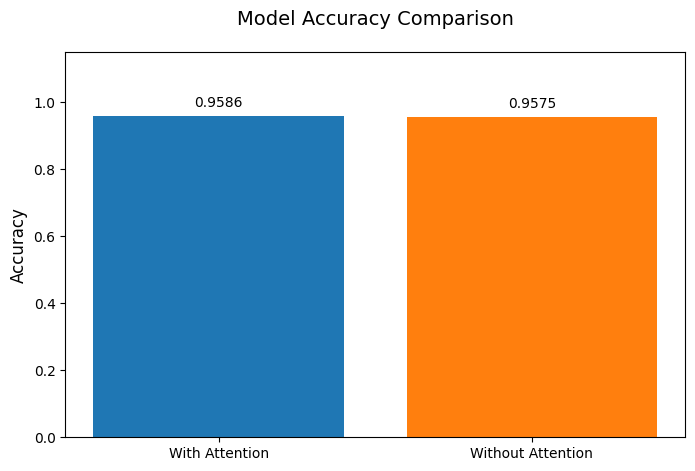

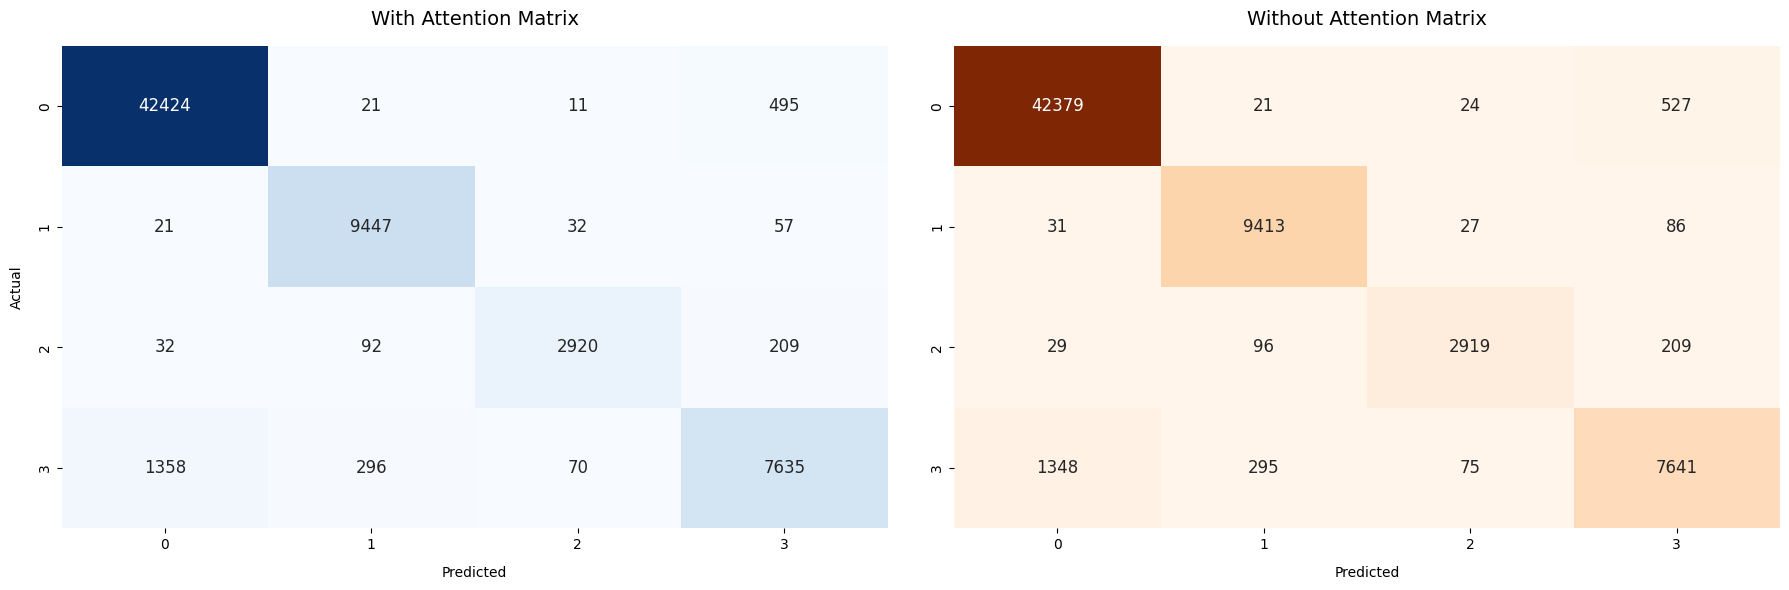


📊 Attention Model Report:
              precision    recall  f1-score   support

      Class0       0.97      0.99      0.98     42951
      Class1       0.96      0.99      0.97      9557
      Class2       0.96      0.90      0.93      3253
      Class3       0.91      0.82      0.86      9359

    accuracy                           0.96     65120
   macro avg       0.95      0.92      0.94     65120
weighted avg       0.96      0.96      0.96     65120


📊 Non-Attention Model Report:
              precision    recall  f1-score   support

      Class0       0.97      0.99      0.98     42951
      Class1       0.96      0.98      0.97      9557
      Class2       0.96      0.90      0.93      3253
      Class3       0.90      0.82      0.86      9359

    accuracy                           0.96     65120
   macro avg       0.95      0.92      0.93     65120
weighted avg       0.96      0.96      0.96     65120



In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                            classification_report, ConfusionMatrixDisplay)

def visualize_comparisons(y_true, preds_attn, preds_noattn, classes):
    # 1️⃣ Accuracy Comparison
    acc_attn = accuracy_score(y_true, preds_attn)
    acc_noattn = accuracy_score(y_true, preds_noattn)
    
    plt.figure(figsize=(8, 5))
    bars = plt.bar(['With Attention', 'Without Attention'], 
                  [acc_attn, acc_noattn], 
                  color=['#1f77b4', '#ff7f0e'])
    plt.title("Model Accuracy Comparison", fontsize=14, pad=20)
    plt.ylim(0, 1.15)
    plt.ylabel("Accuracy", fontsize=12)
    plt.xticks(fontsize=10)
    
    # Add accuracy values on top
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.show()

    # 2️⃣ Confusion Matrices (Dual View)
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # Attention Model
    cm_attn = confusion_matrix(y_true, preds_attn)
    sns.heatmap(cm_attn, annot=True, fmt='d', ax=ax[0], cmap='Blues',
               cbar=False, annot_kws={'size': 12})
    ax[0].set_title("With Attention Matrix", pad=15, fontsize=14)
    ax[0].set_xlabel("Predicted", labelpad=10)
    ax[0].set_ylabel("Actual", labelpad=10)
    
    # Non-Attention Model
    cm_noattn = confusion_matrix(y_true, preds_noattn)
    sns.heatmap(cm_noattn, annot=True, fmt='d', ax=ax[1], cmap='Oranges',
               cbar=False, annot_kws={'size': 12})
    ax[1].set_title("Without Attention Matrix", pad=15, fontsize=14)
    ax[1].set_xlabel("Predicted", labelpad=10)
    ax[1].set_ylabel(" ", labelpad=10)
    
    plt.tight_layout()
    plt.show()

    # 3️⃣ Classification Reports
    print("\n📊 Attention Model Report:")
    print(classification_report(y_true, preds_attn, target_names=classes))
    
    print("\n📊 Non-Attention Model Report:")
    print(classification_report(y_true, preds_noattn, target_names=classes))

# 4️⃣ Model Architecture Visualization (Requires torchviz)
from torchviz import make_dot

def visualize_model_architecture(model, sample_input):
    model.eval()
    with torch.no_grad():
        outputs = model(sample_input)
    make_dot(outputs, params=dict(model.named_parameters())).render("model_arch", format="png")

# 5️⃣ Attention Weights Visualization (For attention model only)
def visualize_attention_patterns(model, sample_input):
    model.eval()
    with torch.no_grad():
        # Modified forward pass to return attention weights
        x = model.relu(model.conv1(sample_input))
        x = x.permute(0, 2, 1)
        lstm_out, _ = model.bilstm(x)
        attn_weights = torch.softmax(model.attn(lstm_out), dim=1)
    
    plt.figure(figsize=(10, 4))
    sns.heatmap(attn_weights.squeeze().numpy(), cmap='viridis')
    plt.title("Attention Weight Distribution Across Features")
    plt.xlabel("Sequence Position")
    plt.ylabel("Attention Weight")
    plt.show()



# Generate predictions if not already available
model_attention.eval()
model_no_attention.eval()
with torch.no_grad():
    preds_attn = torch.argmax(model_attention(X_test_tensor), dim=1).numpy()
    preds_noattn = torch.argmax(model_no_attention(X_test_tensor), dim=1).numpy()

# Run visualizations
visualize_comparisons(y_test, preds_attn, preds_noattn, classes=['Class0', 'Class1', 'Class2', 'Class3'])



## 📌 Conclusion: Attention vs Non-Attention Architecture

Both models — with and without the attention mechanism — yielded **comparable performance**, each achieving an impressive **96% accuracy** across the multi-class classification task for malicious URL detection. However, subtle differences justify the inclusion of the attention mechanism in critical areas:

### 🔍 Key Observations:
- **Class-wise Recall & F1 Score**:  
  The attention-based model demonstrated **slightly improved recall for Class1 and Class3**, which are often harder to classify due to their overlapping feature patterns.
  
- **Model Robustness**:  
  Attention mechanisms **dynamically weigh input features**, helping the model focus more on critical sequences or attributes (e.g., presence of IPs, specific token patterns in URLs). This becomes especially helpful when dealing with **longer or noisier URLs**.

- **Interpretability**:  
  With attention, we can **visualize what parts of the input the model focuses on**, which is crucial for debugging, security auditing, and model explainability — especially in domains like cybersecurity.

### 🧠 Why Use Attention?
Even though both architectures performed similarly in terms of accuracy:
- Attention allows the model to **capture contextual relevance** in temporal sequences better than BiLSTM alone.
- It provides **more stable learning**, especially in longer or complex input cases.
- It offers **interpretability**, which is a significant advantage in high-stakes environments (like phishing detection, malware classification, etc.).

### ✅ Final Verdict:
While traditional models may suffice in many scenarios, **integrating attention mechanisms adds depth, focus, and interpretability**, making the architecture more **resilient and insightful** — a valuable asset in cybersecurity applications.
